# DATA 607 - Machine Learning

## Class 9 &mdash; 2025.03.24 &mdash; More deep learning. Time series.

### Fine-tuning deep learning models with PyTorch

[Cats and Dogs &mdash; Colab notebook](https://colab.research.google.com/drive/18p5x_boWvoUnWf89R-40-oz_JVlB5k-o?usp=sharing)

[Modern Bert/Huggingface](https://colab.research.google.com/drive/1mI5BhPThUcVrl8iJSsJ6KwVko07jzGtG)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
    parse_dates=["Month"],
    index_col="Month",
)
df.index.name = "Date"
df["logPassengers"] = np.log(df["Passengers"])
df

Passengers  logPassengers
Date                                 
1949-01-01         112       4.718499
1949-02-01         118       4.770685
1949-03-01         132       4.882802
1949-04-01         129       4.859812
1949-05-01         121       4.795791
...                ...            ...
1960-08-01         606       6.406880
1960-09-01         508       6.230481
1960-10-01         461       6.133398
1960-11-01         390       5.966147
1960-12-01         432       6.068426

[144 rows x 2 columns]

### Linear trend

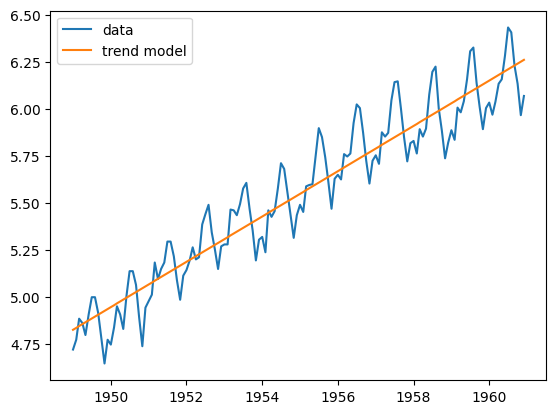

In [3]:
trend_model = LinearRegression()
X = np.arange(len(df)).reshape(-1, 1)
y = df["logPassengers"]
trend_model.fit(X, y)
df["Trend"] = trend_model.predict(X)
plt.plot(df["logPassengers"], label="data")
plt.plot(df["Trend"], label="trend model")
plt.legend()
plt.show()

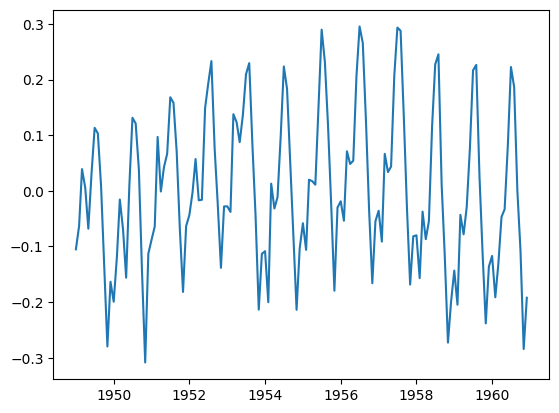

In [4]:
df["Detrended"] = df["logPassengers"] - df["Trend"]
plt.plot(df["Detrended"])

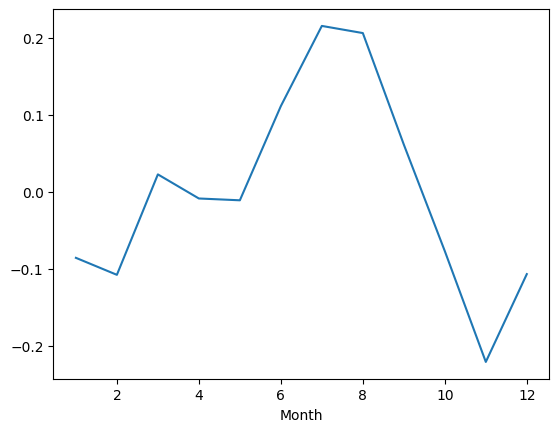

In [5]:
df["Month"] = df.index.month
means = df.groupby("Month")["Detrended"].mean()
plt.plot(means)
plt.xlabel("Month")
plt.show()

### Seasonality

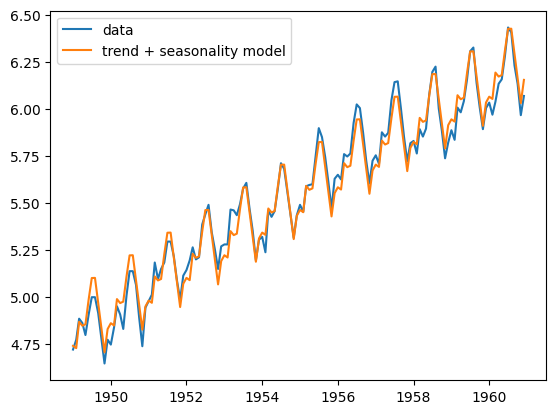

In [6]:
df["Seasonality"] = df["Month"].map(means)
plt.plot(df["logPassengers"], label="data")
plt.plot(df["Trend"] + df["Seasonality"], label="trend + seasonality model")
plt.legend()
plt.show()

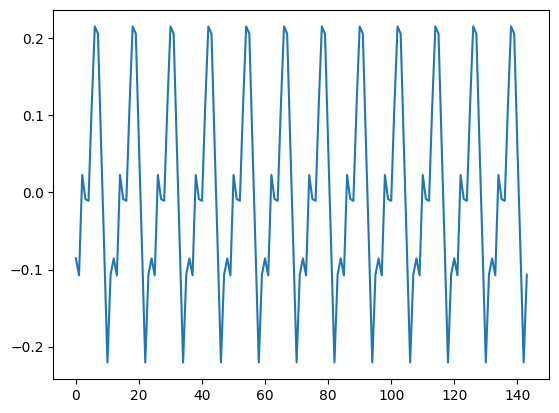

In [7]:
X = pd.get_dummies(df["Month"], prefix="Month")
y = df["Detrended"]
seasonality_model = LinearRegression(fit_intercept=False)
seasonality_model.fit(X, y)
plt.plot(seasonality_model.predict(X))

In [8]:
assert np.allclose(seasonality_model.predict(X), df["Seasonality"])

### Decomposition

$$
X_t = T_t + S_t + R_t
$$

- $T$ is ***trend***, $S$ is ***seasonality***, and $R$ is ***residual***.

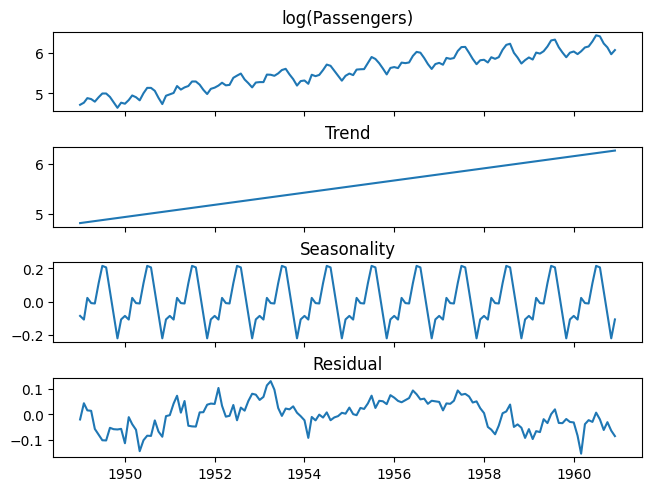

In [ ]:
fig, (a0, a1, a2, a3) = plt.subplots(
    nrows=4, ncols=1, sharex=True, layout="constrained"
)
a0.plot(df["logPassengers"])
a0.set_title("log(Passengers)")
a1.plot(df["Trend"])
a1.set_title("Trend")
a2.plot(df["Seasonality"])
a2.set_title("Seasonality")
a3.plot(df["logPassengers"] - df["Trend"] - df["Seasonality"])
a3.set_title("Residual")
plt.show()

In [10]:
x = df["Detrended"].copy().values

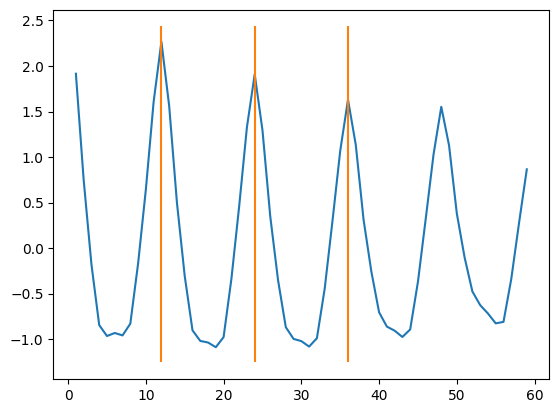

In [11]:
u = [x[k:].dot(x[:-k]) for k in range(1, 60)]
plt.plot(range(1, 60), u)
plt.vlines([12, 24, 36], *plt.ylim(), color="C1")

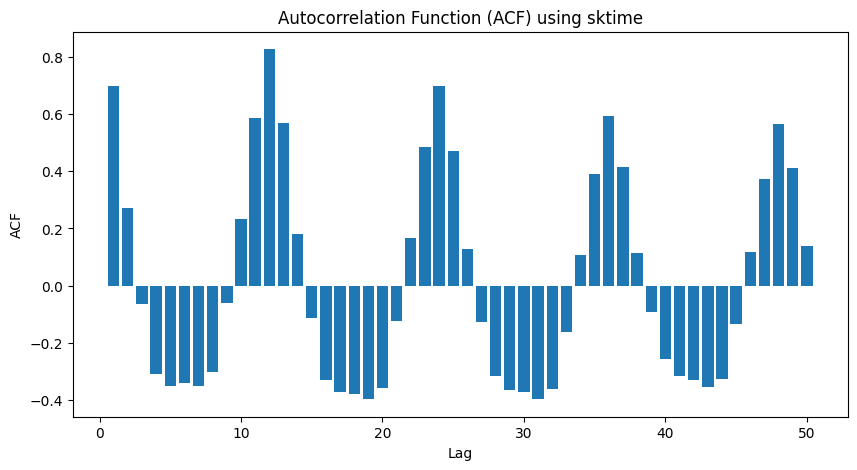

In [12]:
from sktime.utils.plotting import plot_series
from sktime.transformations.series.acf import AutoCorrelationTransformer
import matplotlib.pyplot as plt
import numpy as np

# Compute ACF using sktime
acf_transformer = AutoCorrelationTransformer(n_lags=50)  # Adjust lags as needed
acf_values = acf_transformer.fit_transform(df["Detrended"])

# Plot ACF
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 51), acf_values[1:])  # Exclude lag 0
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.title("Autocorrelation Function (ACF) using sktime")
plt.show()

In [ ]:
houst = pd.read_csv("~/Downloads/HOUST.csv", parse_dates=["observation_date"]).set_index("observation_date")
gdpc1 = pd.read_csv("~/Downloads/GDPC1.csv", parse_dates=["observation_date"]).set_index("observation_date")


In [148]:
df = pd.concat([houst, gdpc1], axis=1)
df["GDPC1"] = df["GDPC1"].interpolate(method="linear")
df["GDP_CHANGE"] = df["GDPC1"].diff()
df = df.dropna().iloc[:-4]
df

HOUST         GDPC1  GDP_CHANGE
observation_date                                 
1959-02-01         1667   3377.308333   25.179333
1959-03-01         1620   3402.487667   25.179333
1959-04-01         1590   3427.667000   25.179333
1959-05-01         1498   3428.463667    0.796667
1959-06-01         1503   3429.260333    0.796667
...                 ...           ...         ...
2024-06-01         1329  23341.498000   58.796000
2024-07-01         1262  23400.294000   58.796000
2024-08-01         1379  23445.627000   45.333000
2024-09-01         1355  23490.960000   45.333000
2024-10-01         1344  23536.293000   45.333000

[789 rows x 3 columns]

In [250]:
from sktime.transformations.series.lag import Lag

gdp_lagger = Lag(lags=[1, 2, 3, 4, 5])
gdp_lag_features = gdp_lagger.fit_transform(df["GDP_CHANGE"])

houst_lagger = Lag(lags=[1, 2, 3, 4, 5])
houst_lag_features = houst_lagger.fit_transform(df["HOUST"])

X = pd.concat([df["HOUST"].copy(), gdp_lag_features, houst_lag_features, pd.get_dummies(df["HOUST"].index.month)], axis=1)
# X = X.dropna()

In [251]:
X

HOUST  lag_1__GDP_CHANGE  lag_2__GDP_CHANGE  \
1959-02-01 00:00:00  1667.0                NaN                NaN   
1959-03-01 00:00:00  1620.0          25.179333                NaN   
1959-04-01 00:00:00  1590.0          25.179333          25.179333   
1959-05-01 00:00:00  1498.0          25.179333          25.179333   
1959-06-01 00:00:00  1503.0           0.796667          25.179333   
...                     ...                ...                ...   
784                     NaN                NaN                NaN   
785                     NaN                NaN                NaN   
786                     NaN                NaN                NaN   
787                     NaN                NaN                NaN   
788                     NaN                NaN                NaN   

                     lag_3__GDP_CHANGE  lag_4__GDP_CHANGE  lag_5__GDP_CHANGE  \
1959-02-01 00:00:00                NaN                NaN                NaN   
1959-03-01 00:00:00                NaN                NaN                NaN   
1959-04-01 00:00:00                NaN                NaN                NaN   
1959-05-01 00:00:00          25.179333                NaN                NaN   
1959-06-01 00:00:00          25.179333          25.179333                NaN   
...                                ...                ...                ...   
784                                NaN                NaN                NaN   
785                                NaN                NaN                NaN   
786                                NaN                NaN                NaN   
787                                NaN                NaN                NaN   
788                                NaN                NaN                NaN   

                     lag_1__HOUST  lag_2__HOUST  lag_3__HOUST  lag_4__HOUST  \
1959-02-01 00:00:00           NaN           NaN           NaN           NaN   
1959-03-01 00:00:00        1667.0           NaN           NaN           NaN   
1959-04-01 00:00:00        1620.0        1667.0           NaN           NaN   
1959-05-01 00:00:00        1590.0        1620.0        1667.0           NaN   
1959-06-01 00:00:00        1498.0        1590.0        1620.0        1667.0   
...                           ...           ...           ...           ...   
784                           NaN           NaN           NaN           NaN   
785                           NaN           NaN           NaN           NaN   
786                           NaN           NaN           NaN           NaN   
787                           NaN           NaN           NaN           NaN   
788                           NaN           NaN           NaN           NaN   

                     ...      3      4      5      6      7      8      9  \
1959-02-01 00:00:00  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-03-01 00:00:00  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-04-01 00:00:00  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-05-01 00:00:00  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1959-06-01 00:00:00  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
784                  ...  False  False  False   True  False  False  False   
785                  ...  False  False  False  False   True  False  False   
786                  ...  False  False  False  False  False   True  False   
787                  ...  False  False  False  False  False  False   True   
788                  ...  False  False  False  False  False  False  False   

                        10     11     12  
1959-02-01 00:00:00    NaN    NaN    NaN  
1959-03-01 00:00:00    NaN    NaN    NaN  
1959-04-01 00:00:00    NaN    NaN    NaN  
1959-05-01 00:00:00    NaN    NaN    NaN  
1959-06-01 00:00:00    NaN    NaN    NaN  
...                    ...    ...    ...  
784                  False  False  False  
785           

In [241]:
X_train = X.iloc[:650]
y_train = X_train.pop("HOUST")
X_test = X.iloc[650:]
y_test = X_test.pop("HOUST")

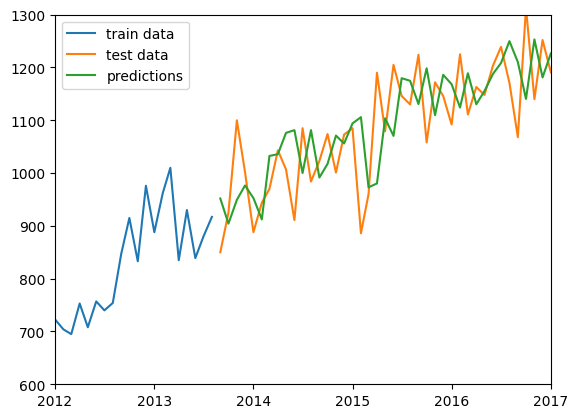

In [242]:
model = LinearRegression()
model.fit(X_train, y_train)
plt.plot(y_train.index, y_train, label="train data")

plt.plot(y_test.index, y_test, label="test data")
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

plt.plot(y_pred.index, y_pred, label="predictions")
t0 = pd.Timestamp(year=2012, month=1, day=1)
t1 = pd.Timestamp(year=2017, month=1, day=1)
plt.xlim(t0, t1)
plt.ylim(600, 1300)
plt.legend()
plt.show()

In [239]:
list(zip(model.feature_names_in_, model.coef_))

[('lag_1__GDP_CHANGE', np.float64(1.2289892106461477)),
 ('lag_2__GDP_CHANGE', np.float64(-0.052360717889338916)),
 ('lag_3__GDP_CHANGE', np.float64(-0.14827681475195478)),
 ('lag_4__GDP_CHANGE', np.float64(-0.00449999611571808)),
 ('lag_5__GDP_CHANGE', np.float64(-0.20557761292930232)),
 ('lag_1__HOUST', np.float64(0.5776540547602295)),
 ('lag_2__HOUST', np.float64(0.22217241375143476)),
 ('lag_3__HOUST', np.float64(0.1407013111682337)),
 ('lag_4__HOUST', np.float64(0.08228715256029076)),
 ('lag_5__HOUST', np.float64(-0.06553113063032702)),
 ('month', np.float64(1.286134368703977)),
 ('year', np.float64(-0.6776007216565381))]

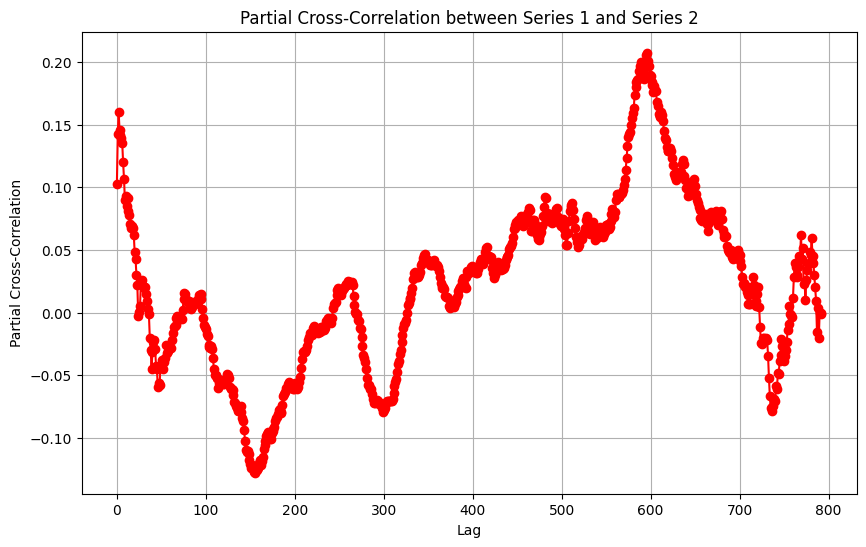

In [140]:
from statsmodels.tsa.stattools import ccf

# Partial Cross-Correlation (CCF) calculation
ccf_values = ccf(df["HOUST"], df["GDP_CHANGE"])

# Plot the Partial Cross-Correlation
plt.figure(figsize=(10, 6))
plt.plot(range(len(ccf_values)), ccf_values, marker='o', linestyle='-', color='r')
plt.title("Partial Cross-Correlation between Series 1 and Series 2")
plt.xlabel("Lag")
plt.ylabel("Partial Cross-Correlation")
plt.grid(True)
plt.show()

In [ ]:
x = df["GDPC1"].values.copy()
x[1:-1:3] = (2 * x[:-2:3] + 1 * x[3::3]) / 3
x[2:-1:3] = (1 * x[:-2:3] + 2 * x[3::3]) / 3
df["GPC1_Linear"] = x
df = df.iloc[:-4]
df

observation_date  HOUST      GDPC1   GPC1_Linear
0         1959-01-01   1657   3352.129   3352.129000
1         1959-02-01   1667        NaN   3377.308333
2         1959-03-01   1620        NaN   3402.487667
3         1959-04-01   1590   3427.667   3427.667000
4         1959-05-01   1498        NaN   3428.463667
..               ...    ...        ...           ...
785       2024-06-01   1329        NaN  23341.498000
786       2024-07-01   1262  23400.294  23400.294000
787       2024-08-01   1379        NaN  23445.627000
788       2024-09-01   1355        NaN  23490.960000
789       2024-10-01   1344  23536.293  23536.293000

[790 rows x 4 columns]

(-100.0, 100.0)

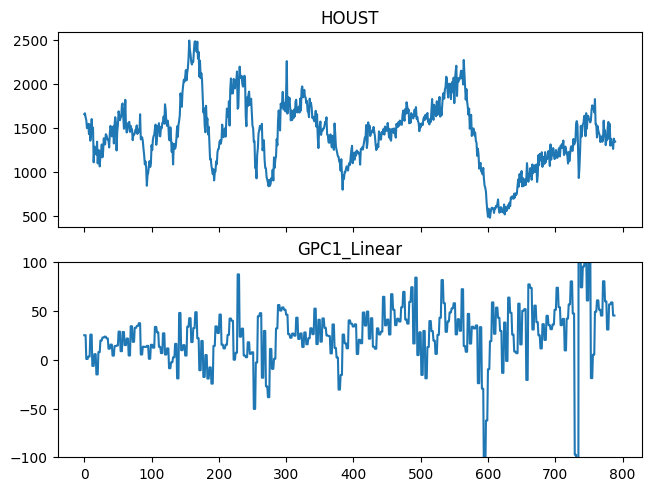

In [ ]:
fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, sharex=True, layout="constrained")
a0.plot(df["HOUST"])
a0.set_title("HOUST")
a1.plot(np.diff(df["GPC1_Linear"]))
a1.set_title("GPC1_Linear")
a1.set_ylim(-100, 100)

In [17]:
df = df.iloc[:-4]
df

observation_date  HOUST      GDPC1   GPC1_Linear
0         1959-01-01   1657   3352.129   3352.129000
1         1959-02-01   1667        NaN   3377.308333
2         1959-03-01   1620        NaN   3402.487667
3         1959-04-01   1590   3427.667   3427.667000
4         1959-05-01   1498        NaN   3428.463667
..               ...    ...        ...           ...
781       2024-02-01   1546        NaN  23110.332000
782       2024-03-01   1299        NaN  23167.119000
783       2024-04-01   1377  23223.906  23223.906000
784       2024-05-01   1315        NaN  23282.702000
785       2024-06-01   1329        NaN  23341.498000

[786 rows x 4 columns]

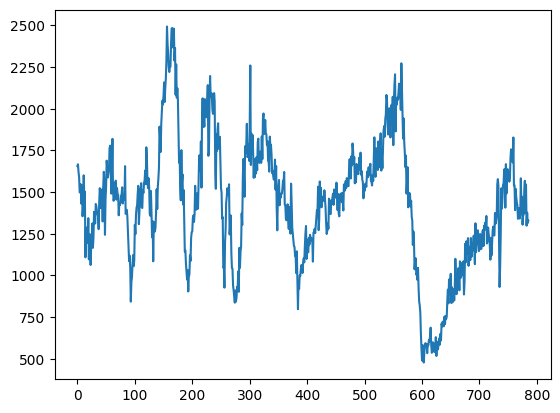

In [18]:
plt.plot(df["HOUST"])

/var/folders/v0/pv7p2b9s1jqd_6qkvz6jxpsh0000gn/T/ipykernel_32607/2295971867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MA_12"] = df["HOUST"].rolling(window=12).mean()  # 12-month moving average


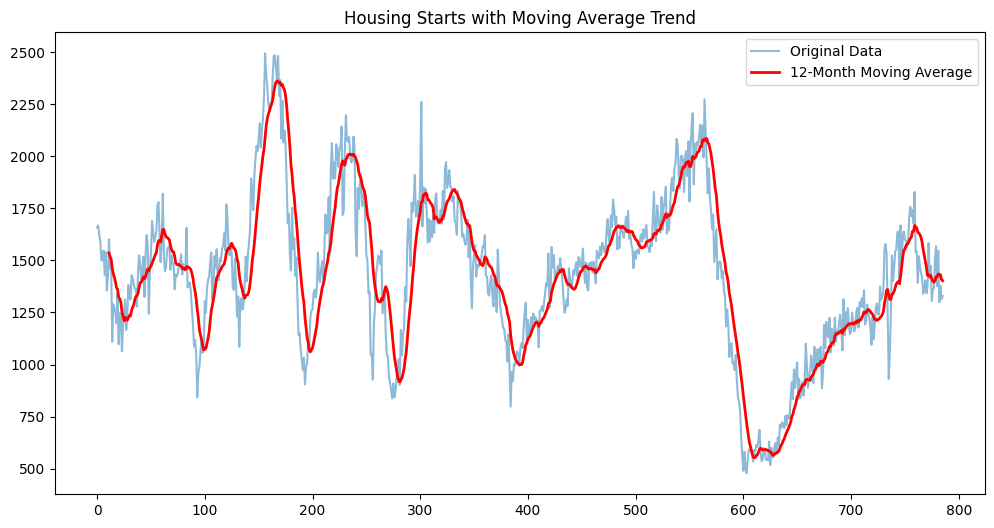

In [19]:
df["MA_12"] = df["HOUST"].rolling(window=12).mean()  # 12-month moving average

plt.figure(figsize=(12, 6))
plt.plot(df["HOUST"], alpha=0.5, label="Original Data")
plt.plot(df["MA_12"], label="12-Month Moving Average", color="red", linewidth=2)
plt.title("Housing Starts with Moving Average Trend")
plt.legend()
plt.show()

(-50.0, 100.0)

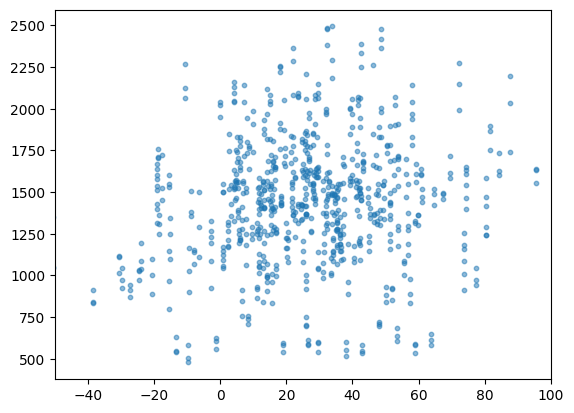

In [20]:
plt.scatter(np.diff(df["GPC1_Linear"]), df["HOUST"][1:], s=10, alpha=0.5)
plt.xlim(-50, 100)

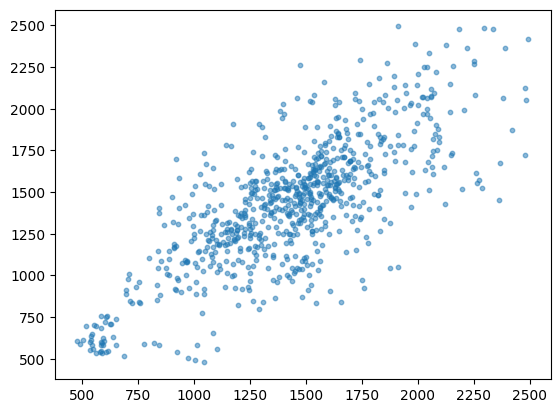

In [21]:
plt.scatter(df["HOUST"][:-10], df["HOUST"][10:], s=10, alpha=0.5)

In [22]:
df

observation_date  HOUST      GDPC1   GPC1_Linear        MA_12
0         1959-01-01   1657   3352.129   3352.129000          NaN
1         1959-02-01   1667        NaN   3377.308333          NaN
2         1959-03-01   1620        NaN   3402.487667          NaN
3         1959-04-01   1590   3427.667   3427.667000          NaN
4         1959-05-01   1498        NaN   3428.463667          NaN
..               ...    ...        ...           ...          ...
781       2024-02-01   1546        NaN  23110.332000  1434.500000
782       2024-03-01   1299        NaN  23167.119000  1430.916667
783       2024-04-01   1377  23223.906  23223.906000  1431.666667
784       2024-05-01   1315        NaN  23282.702000  1409.333333
785       2024-06-01   1329        NaN  23341.498000  1402.166667

[786 rows x 5 columns]